In [74]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from functions.naming import rename_columns
from sklearn.metrics import mean_squared_error
import math

df = pd.read_excel("/Users/athanasioskaravangelis/Desktop/RSM BAM/Workshop/pko_forecasting/data/PKO_Initial_Dataset.xlsx")
#rename columns
df = rename_columns(df)
# select only the values after 2010-01-01
df['date'] = pd.to_datetime(df['date'], format='%b-%y')
df = df[df['date'] > '2009-12-02']

df.head()

,ONI,Precipitation_Indonesia,Precipitation_Malaysia,Temperaturemin_Indonesia,Temperaturemin_Malaysia,Temperaturemax_Indonesia,Temperaturemax_Malaysia,Humidex_Indonesia,Humidex_Malaysia,date,...,pko_exports_indonesia,pko_exports_malaysia,pko_total_supply_indonesia,pko_total_supply_malaysia,pmi_indonesia,pmi_malaysia,export_tarrifs_indonesia,cpopc_mal_ind_2015,mspo_certification,ispo_certification
48,NaN,0.418410,0.361239,22.33558,22.47141,30.71202,31.12185,35.65479,36.57903,2010-01-01,...,NaN,NaN,NaN,NaN,NaN,NaN,100.0,0.0,0.0,0.0
49,NaN,0.347598,0.176073,22.71100,22.48973,31.22701,32.42118,36.78451,37.94791,2010-02-01,...,NaN,NaN,NaN,NaN,NaN,NaN,100.0,0.0,0.0,0.0
50,NaN,0.429777,0.244998,22.81132,23.15041,31.30822,33.46994,36.81526,38.26780,2010-03-01,...,NaN,NaN,NaN,NaN,NaN,NaN,100.0,0.0,0.0,0.0
51,NaN,0.412347,0.294569,23.15416,23.68263,31.53292,32.85302,37.50045,39.29284,2010-04-01,...,NaN,NaN,NaN,NaN,NaN,NaN,100.0,0.0,0.0,0.0
52,NaN,0.402333,0.315503,23.38245,23.89869,31.51028,32.93819,37.76451,39.94663,2010-05-01,...,NaN,NaN,NaN,NaN,NaN,NaN,100.0,0.0,0.0,0.0


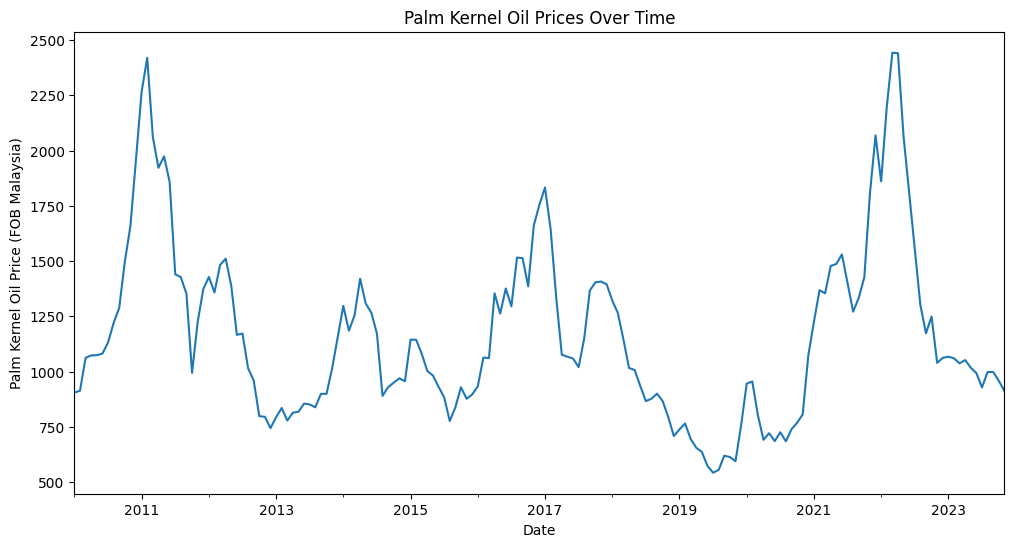

In [75]:
# Set 'date' as the index
df.set_index('date', inplace=True)

# Plot the time series data
df['pko_fob_malaysia'].plot(figsize=(12, 6))
plt.title('Palm Kernel Oil Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Palm Kernel Oil Price (FOB Malaysia)')
plt.show()

In [76]:
from statsmodels.tsa.stattools import adfuller

# Function to check stationarity
def test_stationarity(timeseries):
    # Dickey-Fuller test
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])

# Check stationarity
test_stationarity(df['pko_fob_malaysia'])


ADF Statistic: -3.3622948511012343
p-value: 0.012313391767580891
Critical Values: {'1%': -3.4732590518613002, '5%': -2.880374082105334, '10%': -2.5768120811654525}


## Autocorrelation function (ACF) and partial autocorrelation function (PACF) plots 
These plots help us  to identify the lag values where the ACF and PACF plots drop to zero. These lag values can guide our choice of p and q. The parameter d is the differencing order, which in our case is not needed.

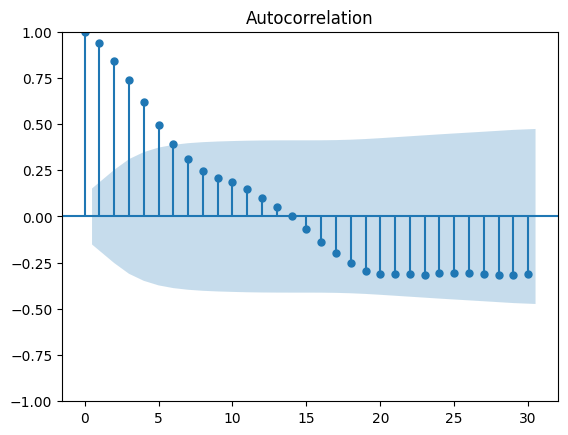

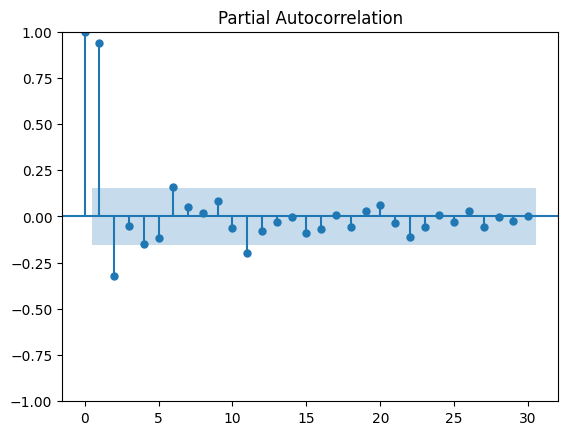

In [77]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF and PACF plots
plot_acf(df['pko_fob_malaysia'].dropna(), lags=30)
plot_pacf(df['pko_fob_malaysia'].dropna(), lags=30)
plt.show()

In [78]:
import math
# Split the data into training and test sets
train_size = int(len(df) - 12)  # 80% for training, 20% for testing
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Define the range of values for p, d, and q
p_values = range(4, 8)  # Adjust as needed
q_values = range(0, 5)  # Adjust as needed

best_rmse = float('inf')
best_order = None

# Iterate through different combinations of p, d, and q
for p in p_values:
    for q in q_values:
        # Fit ARIMA model on the training set
        model = ARIMA(train['pko_fob_malaysia'], order=(p, 0, q))
        results = model.fit()

        # Forecast on the test set
        forecast_steps = len(test)
        forecast = results.get_forecast(steps=forecast_steps)
        predicted_values = forecast.predicted_mean

        # Calculate RMSE
        rmse = math.sqrt(mean_squared_error(test['pko_fob_malaysia'], predicted_values))

        # Update best RMSE and order if the current model performs better
        if rmse < best_rmse:
            best_rmse = rmse
            best_order = (p, 0, q)
            best_values = predicted_values

# Print the best order and corresponding RMSE
print('Best Order (p, d, q):', best_order)
print('Best Root Mean Squared Error (RMSE):', best_rmse)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.f

Best Order (p, d, q): (7, 0, 4)
Best Root Mean Squared Error (RMSE): 105.50969456763903


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [79]:
predicted_values, test['pko_fob_malaysia']

(2022-12-01     914.610495
 2023-01-01     940.414215
 2023-02-01     933.367691
 2023-03-01     871.749532
 2023-04-01     874.700052
 2023-05-01     949.951972
 2023-06-01     917.612266
 2023-07-01     910.105704
 2023-08-01     967.170923
 2023-09-01    1003.527972
 2023-10-01     965.522647
 2023-11-01    1009.594341
 Freq: MS, Name: predicted_mean, dtype: float64,
 date
 2022-12-01    1062.0
 2023-01-01    1067.0
 2023-02-01    1060.0
 2023-03-01    1037.0
 2023-04-01    1052.0
 2023-05-01    1017.0
 2023-06-01     993.0
 2023-07-01     928.0
 2023-08-01     998.0
 2023-09-01     998.0
 2023-10-01     958.0
 2023-11-01     912.0
 Name: pko_fob_malaysia, dtype: float64)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregres

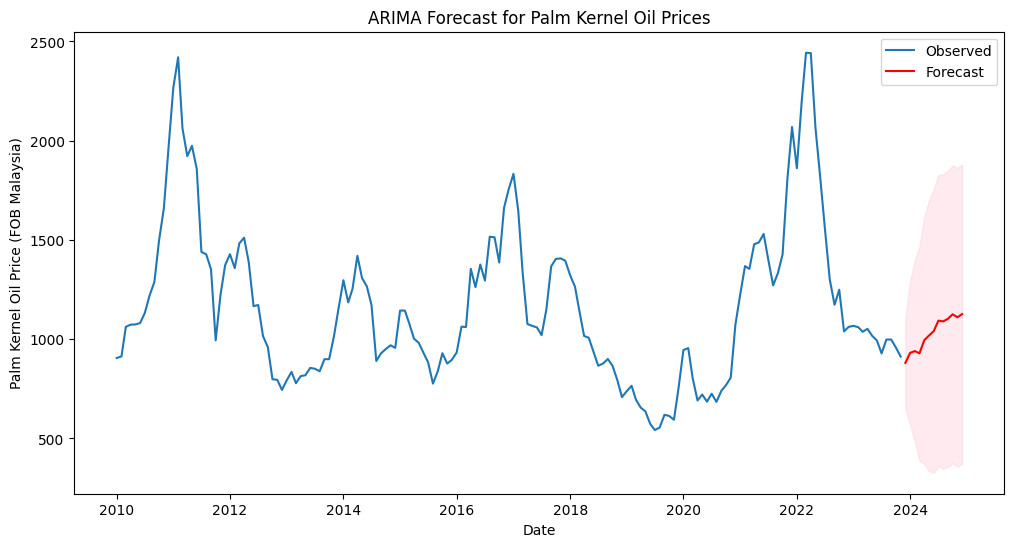

In [94]:
# Fit ARIMA model
model = ARIMA(df['pko_fob_malaysia'], order=(7,0,4))  # Set appropriate values for p, d, and q
results = model.fit()

# Forecast for December 2023 and whole of 2024
forecast_steps = 13  # 1 month for December 2023 and 12 months for 2024
forecast = results.get_forecast(steps=forecast_steps)

# Confidence intervals
ci = forecast.conf_int()

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(df['pko_fob_malaysia'], label='Observed')
plt.plot(forecast.predicted_mean, label='Forecast', color='red')
plt.fill_between(ci.index, ci['lower pko_fob_malaysia'], ci['upper pko_fob_malaysia'], color='pink', alpha=0.3)
plt.title('ARIMA Forecast for Palm Kernel Oil Prices')
plt.xlabel('Date')
plt.ylabel('Palm Kernel Oil Price (FOB Malaysia)')
plt.legend()
plt.show()

In [95]:
# create a df with the dates in the range of dec 2023 to dec 2024 and the froecasted values
forecast_df = pd.DataFrame({'date': pd.date_range(start='2023-12-01', end='2024-12-01', freq='MS'),
                            'pko_fob_malaysia': forecast.prediction_results.forecasts[0]})
forecast_df

,date,pko_fob_malaysia
0,2023-12-01,880.380766
1,2024-01-01,931.054439
2,2024-02-01,940.010467
3,2024-03-01,928.050444
4,2024-04-01,994.699065
5,2024-05-01,1017.650597
6,2024-06-01,1040.316056
7,2024-07-01,1093.251351
8,2024-08-01,1089.334832
9,2024-09-01,1102.941696


In [82]:
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:       pko_fob_malaysia   No. Observations:                  167
Model:                 ARIMA(7, 0, 4)   Log Likelihood               -1036.531
Date:                Sat, 27 Jan 2024   AIC                           2099.063
Time:                        18:40:51   BIC                           2139.597
Sample:                    01-01-2010   HQIC                          2115.514
                         - 11-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1164.9816    138.930      8.385      0.000     892.683    1437.280
ar.L1          1.0691      0.191      5.598      0.000       0.695       1.443
ar.L2         -0.3519      0.231     -1.527      0.1